In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Part One

In [2]:
logins=pd.read_json('logins.json')
logins.head()

login_time
0 1970-01-01 20:13:18
1 1970-01-01 20:16:10
2 1970-01-01 20:16:37
3 1970-01-01 20:16:36
4 1970-01-01 20:26:21

In [3]:
print(logins.shape)

(93142, 1)


In [4]:
logins.index = pd.to_datetime(logins['login_time'])
logins.head()

login_time
login_time                             
1970-01-01 20:13:18 1970-01-01 20:13:18
1970-01-01 20:16:10 1970-01-01 20:16:10
1970-01-01 20:16:37 1970-01-01 20:16:37
1970-01-01 20:16:36 1970-01-01 20:16:36
1970-01-01 20:26:21 1970-01-01 20:26:21

In [5]:
login_counts = logins.resample('15T').count()
login_counts.rename(columns={'login_time': 'count'}, inplace=True)
login_counts.head(15)

count
login_time                
1970-01-01 20:00:00      2
1970-01-01 20:15:00      6
1970-01-01 20:30:00      9
1970-01-01 20:45:00      7
1970-01-01 21:00:00      1
1970-01-01 21:15:00      4
1970-01-01 21:30:00      0
1970-01-01 21:45:00      4
1970-01-01 22:00:00      9
1970-01-01 22:15:00      8
1970-01-01 22:30:00      1
1970-01-01 22:45:00      3
1970-01-01 23:00:00     16
1970-01-01 23:15:00     13
1970-01-01 23:30:00     14

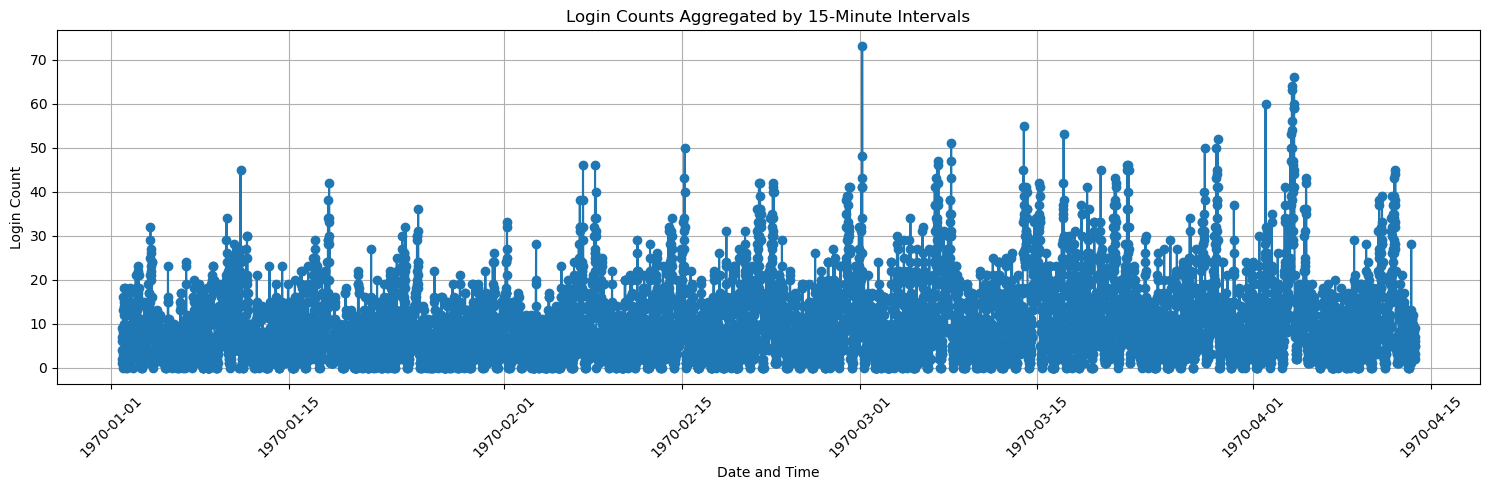

In [6]:
plt.figure(figsize=(15, 5))
plt.plot(login_counts.index, login_counts['count'], marker='o', linestyle='-')
plt.title('Login Counts Aggregated by 15-Minute Intervals')
plt.xlabel('Date and Time')
plt.ylabel('Login Count')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

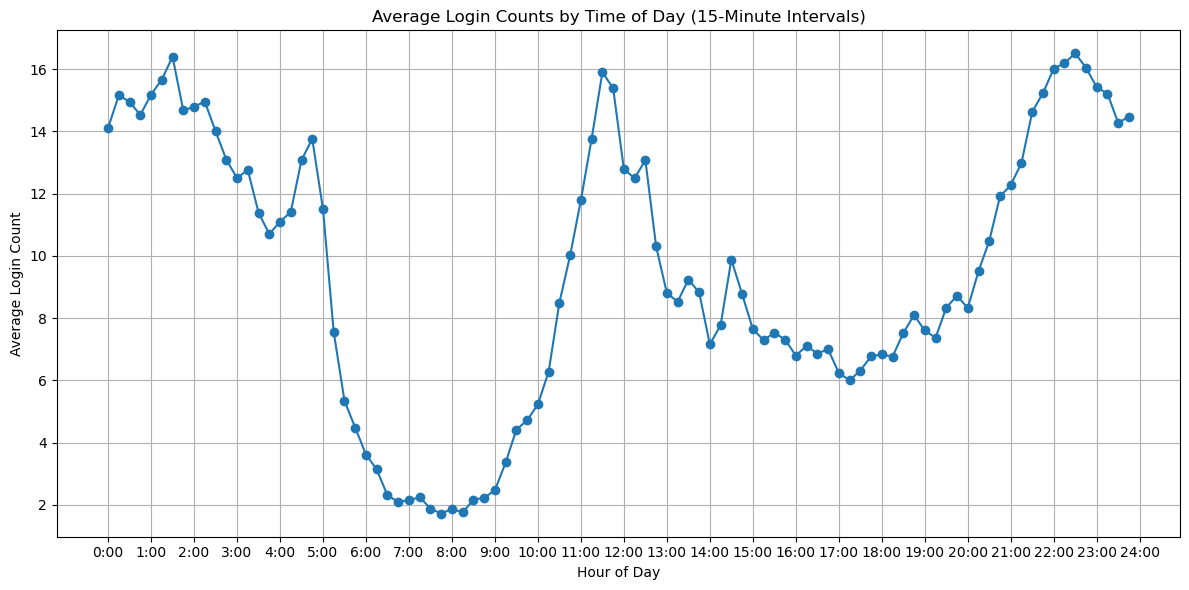

In [7]:
login_counts['hour'] = login_counts.index.hour
login_counts['minute'] = login_counts.index.minute
daily_cycle = login_counts.groupby(['hour', 'minute']).mean()
daily_cycle.reset_index(inplace=True)
daily_cycle['time'] = daily_cycle['hour'].astype(str) + ':' + daily_cycle['minute'].astype(str)
daily_cycle['time'] = pd.to_datetime(daily_cycle['time'], format='%H:%M').dt.time
daily_cycle['time_float'] = daily_cycle['hour'] + daily_cycle['minute'] / 60
plt.figure(figsize=(12, 6))
plt.plot(daily_cycle['time_float'], daily_cycle['count'], marker='o', linestyle='-')
plt.title('Average Login Counts by Time of Day (15-Minute Intervals)')
plt.xlabel('Hour of Day')
plt.ylabel('Average Login Count')
plt.grid(True)
plt.xticks(ticks=range(0, 25), labels=[f"{h}:00" for h in range(25)])
plt.tight_layout()
plt.show()

### Important Features of the Demand

1. **Daily Cycles**:
   - **Peak Times**: There are distinct peaks in login activity. The primary peak occurs late in the evening around midnight, which might suggest significant activity during leisure hours. A secondary peak is observed in the late evening, potentially indicating increased activity as people finish their work or daily activities.
   - **Low Activity**: The lowest activity is consistently found in the early morning hours, particularly around 6 AM, which could be used for performing maintenance or updates when it least disrupts users.

2. **Intraday Variability**:
   - The demand isn't consistent throughout the day but shows significant fluctuation, which underscores the need for dynamic resource allocation by time of day to efficiently manage system load.

### Visualization Insights

- The average daily cycle plot reveals the times with highest and lowest demands, useful for strategic planning in operations and customer service.
- Visualizing the first week provided a clear representation of intraday variations, highlighting the consistency of peak and low times across days.

### Data Quality Issues

Upon initial inspection, there appear to be no evident data quality issues such as missing values, incorrect timestamps, or anomalies in the data formatting. The timestamps are consistently formatted and appropriately parsed as datetime objects. There were no errors or inconsistencies observed during the data aggregation process which would suggest data quality concerns.

The provided login data is robust for analyzing daily user login patterns, and it shows clear cycles of demand that could inform various operational strategies, including staffing, system resource allocation, and timing for maintenance. The lack of data quality issues suggests that the dataset is well-prepared for this kind of temporal analysis.

# Part 3

In [8]:
ultimate_data=pd.read_json('ultimate_data_challenge.json')
ultimate_data.head()

city  trips_in_first_30_days signup_date  avg_rating_of_driver  \
0  King's Landing                       4  2014-01-25                   4.7   
1         Astapor                       0  2014-01-29                   5.0   
2         Astapor                       3  2014-01-06                   4.3   
3  King's Landing                       9  2014-01-10                   4.6   
4      Winterfell                      14  2014-01-27                   4.4   

   avg_surge last_trip_date    phone  surge_pct  ultimate_black_user  \
0       1.10     2014-06-17   iPhone       15.4                 True   
1       1.00     2014-05-05  Android        0.0                False   
2       1.00     2014-01-07   iPhone        0.0                False   
3       1.14     2014-06-29   iPhone       20.0                 True   
4       1.19     2014-03-15  Android       11.8                False   

   weekday_pct  avg_dist  avg_rating_by_driver  
0         46.2      3.67                   5.0  
1         50.0      8.26                   5.0  
2        100.0      0.77                   5.0  
3         80.0      2.36                   4.9  
4         82.4      3.13                   4.9

In [9]:
print(ultimate_data.shape)

(50000, 12)


In [10]:
ultimate_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


The DataSheet has got these columns to looks at
- **City**: Where users Calls Home after they Register.
- **Trips_in_first_30_days**: Them trips users taken that’s are in a first month.
- **Signup_date**: When’s did the person registers?
- **avg_rating_of_driver**: How much stars drivers usually get from this user???
- **avg_surge**: It’s about Average of Surge multiplier During Rides.
- **Last_trip_date**: That’s when was the Last ride! that user did.
- **Phone**: What kind of Phone either an iPhone, Android.
- **Surge_pct**: Percent of surge trips did with them surge factors.
- **Ultimate_black_user**: is user a Ultimate Black One??? Totally Unclear right!
- **weekday_pct**: How many % of rides??? happens on Weekdays - still vague.
- **avg_dist**: that’s average miles a trip gets in a Moon after signing?
- **avg_rating_by_driver**: given by the Drivers to the User,

From some Overviewing, missing parts in Columns like avg_rating_of_driver, Phone also avg_rating_by driver needs Fixing.Also. Dates like signup_date, and last_trip_date, they must transforms to be Datetime. we'll convert the date columns and handle the missing data before calculating the fraction of retained users

In [11]:
# Convert 'signup_date' and 'last_trip_date' to datetime format
ultimate_data['signup_date'] = pd.to_datetime(ultimate_data['signup_date'])
ultimate_data['last_trip_date'] = pd.to_datetime(ultimate_data['last_trip_date'])
# Fill missing values for 'avg_rating_of_driver' and 'avg_rating_by_driver' with their means
ultimate_data['avg_rating_of_driver'].fillna(ultimate_data['avg_rating_of_driver'].mean(), inplace=True)
ultimate_data['avg_rating_by_driver'].fillna(ultimate_data['avg_rating_by_driver'].mean(), inplace=True)
# Replace missing values in 'phone' with the mode
phone_mode = ultimate_data['phone'].mode()[0]
ultimate_data['phone'].fillna(phone_mode, inplace=True)
# Calculate the fraction of retained users
latest_date = ultimate_data['last_trip_date'].max()
cutoff_date = latest_date - pd.Timedelta(days=30)
retained_users = ultimate_data[ultimate_data['last_trip_date'] >= cutoff_date].shape[0]
fraction_retained = retained_users / ultimate_data.shape[0]
fraction_retained, retained_users

(0.37608, 18804)

After the Clean Up of data occurs and addressing those missing values, it has been uncovered that nearly 37.6% of users, or say, 18804 out of a Total of 50000, sticks around according to them criteria given (users who went for a trip in them's last 30 days from latest trip date on this dataset).

Next up, proceeding with more explorations and data analysis is on the agenda.

C:\Users\leopo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\leopo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


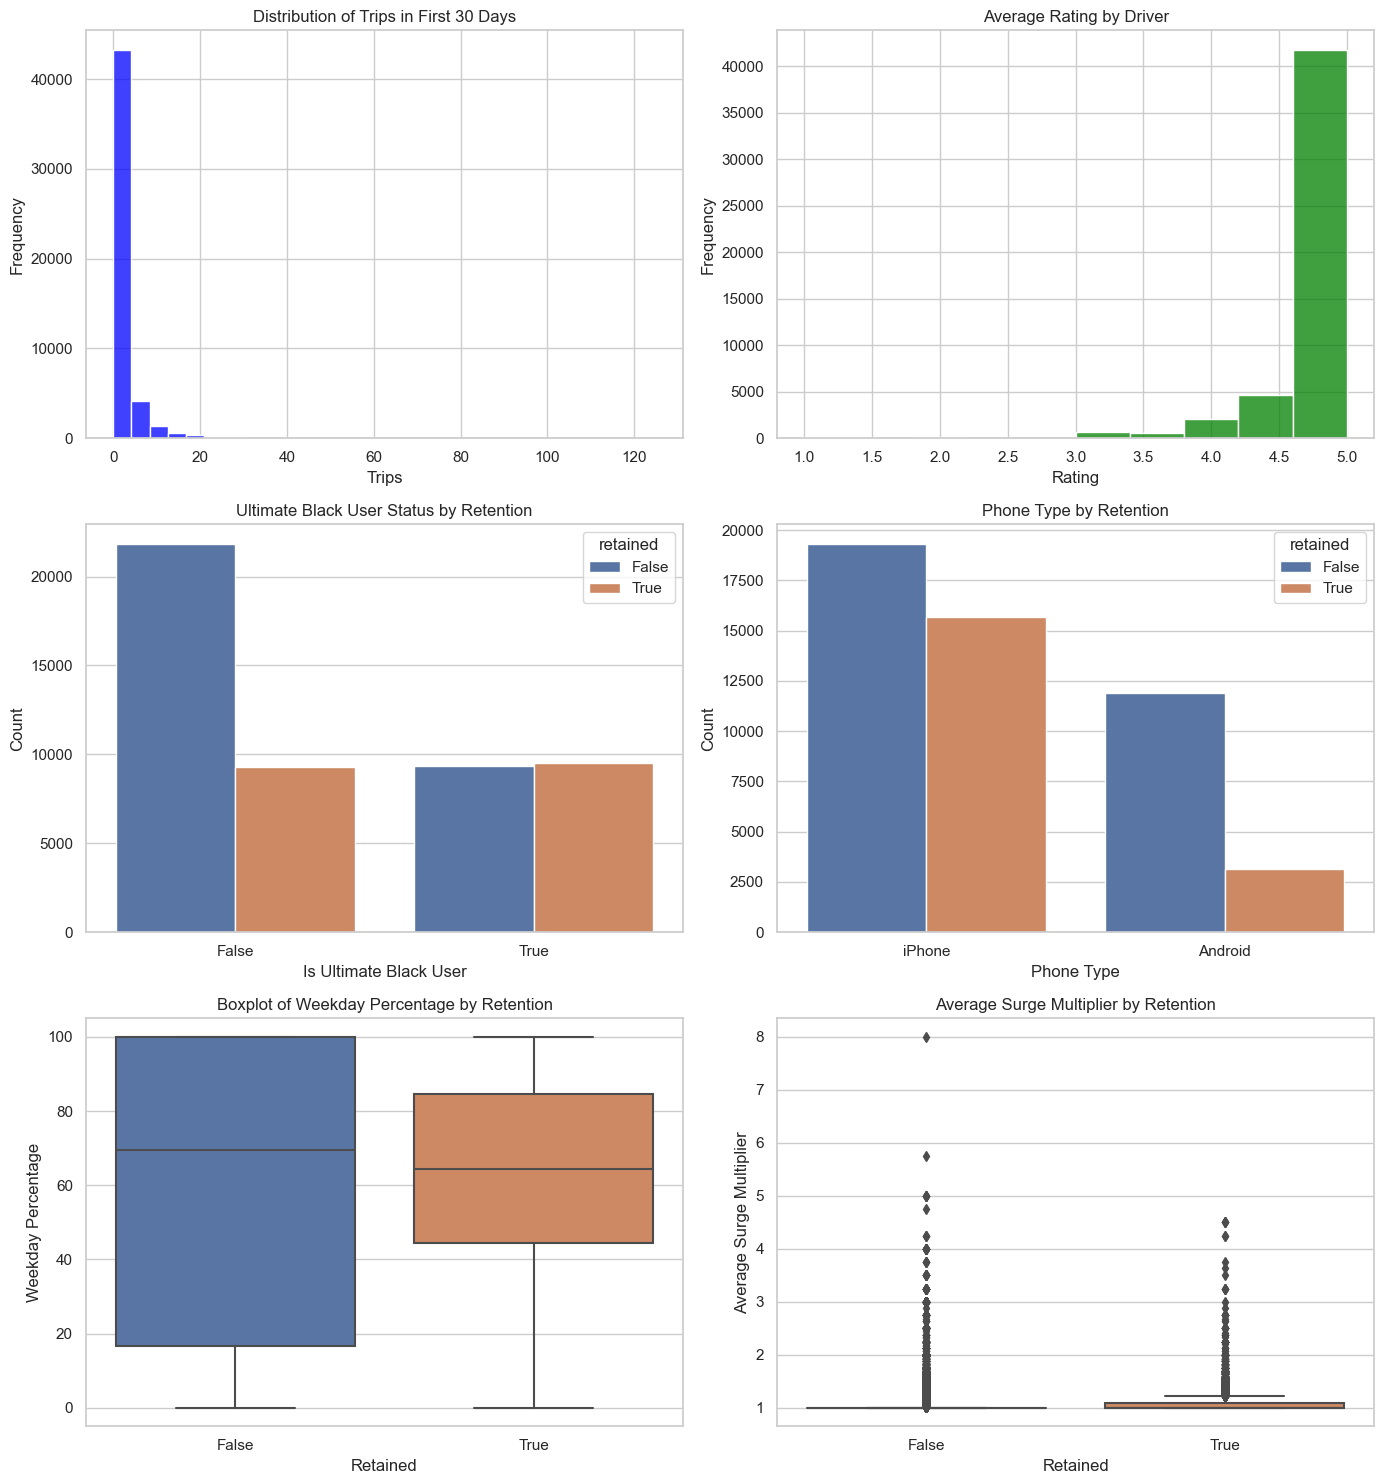

In [12]:
sns.set(style="whitegrid")
ultimate_data['retained'] = ultimate_data['last_trip_date'] >= cutoff_date
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 15))
# Trips in the first 30 days
sns.histplot(ultimate_data['trips_in_first_30_days'], bins=30, ax=axes[0, 0], kde=False, color='blue')
axes[0, 0].set_title('Distribution of Trips in First 30 Days')
axes[0, 0].set_xlabel('Trips')
axes[0, 0].set_ylabel('Frequency')
# Average rating by driver
sns.histplot(ultimate_data['avg_rating_by_driver'], bins=10, ax=axes[0, 1], kde=False, color='green')
axes[0, 1].set_title('Average Rating by Driver')
axes[0, 1].set_xlabel('Rating')
axes[0, 1].set_ylabel('Frequency')
# User Type by Retention
sns.countplot(x='ultimate_black_user', hue='retained', data=ultimate_data, ax=axes[1, 0])
axes[1, 0].set_title('Ultimate Black User Status by Retention')
axes[1, 0].set_xlabel('Is Ultimate Black User')
axes[1, 0].set_ylabel('Count')
# Phone Type by Retention
sns.countplot(x='phone', hue='retained', data=ultimate_data, ax=axes[1, 1])
axes[1, 1].set_title('Phone Type by Retention')
axes[1, 1].set_xlabel('Phone Type')
axes[1, 1].set_ylabel('Count')
# Weekday Pct
sns.boxplot(x='retained', y='weekday_pct', data=ultimate_data, ax=axes[2, 0])
axes[2, 0].set_title('Boxplot of Weekday Percentage by Retention')
axes[2, 0].set_xlabel('Retained')
axes[2, 0].set_ylabel('Weekday Percentage')
# Average Surge Multiplier
sns.boxplot(x='retained', y='avg_surge', data=ultimate_data, ax=axes[2, 1])
axes[2, 1].set_title('Average Surge Multiplier by Retention')
axes[2, 1].set_xlabel('Retained')
axes[2, 1].set_ylabel('Average Surge Multiplier')
plt.tight_layout()
plt.show()

The visualizations provide some useful insights into the data and factors that might influence user retention:

1. **Trips in First 30 Days**: Users who take more trips in their first 30 days seem more likely to be retained.

2. **Average Rating by Driver**: Most users are highly rated by drivers. There is not a significant visual difference in ratings distribution between retained and not retained users, indicating ratings might not be a strong predictor of retention.

3. **Ultimate Black User Status**: Ultimate Black users appear to have a higher retention rate than non-Ultimate Black users. This suggests that the Ultimate Black service might positively impact user retention.

4. **Phone Type**: iPhone users show a higher retention rate compared to Android users. This might suggest differences in app experience across platforms could influence retention.

5. **Weekday Percentage**: The boxplot shows a broad range of weekday usage percentages for both retained and not retained users, indicating no clear trend.

6. **Average Surge Multiplier**: Retained users seem to have slightly lower average surge multipliers, suggesting that higher costs could potentially drive away users.

Next, I will build a predictive model to determine whether a user will be active in their 6th month on the system.

In [13]:

# Encoding categorical variables
le_city = LabelEncoder()
le_phone = LabelEncoder()
ultimate_data['city'] = le_city.fit_transform(ultimate_data['city'])
ultimate_data['phone'] = le_phone.fit_transform(ultimate_data['phone'])
# Feature selection
features = ['city', 'trips_in_first_30_days', 'signup_date', 'avg_rating_of_driver', 'avg_surge',
            'phone', 'surge_pct', 'ultimate_black_user', 'weekday_pct', 'avg_dist', 'avg_rating_by_driver']
target = 'retained'
# Extracting month from signup_date to use as a feature
ultimate_data['signup_month'] = ultimate_data['signup_date'].dt.month

# Updating features to include signup_month and excluding signup_date
features = ['city', 'trips_in_first_30_days', 'avg_rating_of_driver', 'avg_surge',
            'phone', 'surge_pct', 'ultimate_black_user', 'weekday_pct', 'avg_dist', 'avg_rating_by_driver', 'signup_month']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(ultimate_data[features], ultimate_data[target], test_size=0.25, random_state=42)
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Initialize and train the classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_scaled, y_train)
# Predictions
y_pred = clf.predict(X_test_scaled)
y_pred_proba = clf.predict_proba(X_test_scaled)[:, 1]
# Model Evaluation
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
classification_rep = classification_report(y_test, y_pred)
accuracy, roc_auc

(0.75168, 0.8156674713584287)

In [14]:
print(classification_rep)

              precision    recall  f1-score   support

       False       0.80      0.81      0.80      7800
        True       0.67      0.66      0.67      4700

    accuracy                           0.75     12500
   macro avg       0.74      0.73      0.73     12500
weighted avg       0.75      0.75      0.75     12500



The predictive model built using a Random Forest Classifier has yielded the following results:

- **Accuracy**: 75.16%
- **ROC AUC Score**: 0.8156

This indicates a reasonably good model for classifying user retention, as the ROC AUC score is quite strong, suggesting that the model has a good measure of separability between retained and not retained users.

### Model Performance Details:
- **Precision** for predicting not retained users is 80%, and for retained users, it's 67%.
- **Recall** for predicting not retained users is 81%, and for retained users, it's 66%.
- The **F1-score**, which is a balance between precision and recall, is 80% for not retained users and 67% for retained users.
